# InsideAirbnb Temporal Dynamics (InsideAirbnb)

This notebook:
1. Builds a night-level panel dataset (listing × date) for each city + snapshot.
2. Performs seasonality analysis (price + booking probability).
3. Creates temporal train/validation/test splits (Jan–Sep / Oct–Nov / Dec–Feb).
4. Trains XGBoost + Neural Network models for:
   - Regression: price
   - Classification: isBooked
5. Logs Neural Network training to TensorBoard and includes screenshots + interpretation.


In [38]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    roc_auc_score, accuracy_score,
    average_precision_score,
    f1_score, precision_score, recall_score
)

from xgboost import XGBRegressor, XGBClassifier
import tensorflow as tf

pd.set_option("display.max_columns", 200)

tf.keras.backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

cities = {
    "austin": ["2024-12-14", "2025-03-06"],
    "chicago": ["2024-12-18", "2025-03-11"],
    "santa_cruz": ["2024-12-31", "2025-03-28"],
    "washington_dc": ["2024-12-18", "2025-03-13"],
}

projectRoot = Path("..").resolve()
dataRawDir = projectRoot / "data" / "raw"
dataDerivedDir = projectRoot / "data" / "derived"
panelSamplesDir = dataDerivedDir / "panelSamples"

logsDir = projectRoot / "logs"
nnPriceLogsDir = logsDir / "nnPrice"
nnBookedLogsDir = logsDir / "nnBooked"

for d in [panelSamplesDir, nnPriceLogsDir, nnBookedLogsDir]:
    d.mkdir(parents=True, exist_ok=True)

print("projectRoot:", projectRoot)
print("dataRawDir:", dataRawDir)
print("panelSamplesDir:", panelSamplesDir)
print("logsDir:", logsDir)


projectRoot: /Users/hamsikarg/Desktop/insideairbnb-temporal
dataRawDir: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/raw
panelSamplesDir: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples
logsDir: /Users/hamsikarg/Desktop/insideairbnb-temporal/logs


The nightly panel dataset is constructed by merging listing-level attributes with calendar-level availability data, resulting in one row per listing per date. Key variables such as price, booking status, and time-based features are cleaned and verified before downstream analysis.


## Part 1: Dataset Construction (Night-level panel)

For each city + snapshot:
- Load `listings.csv` and `calendar.csv` (or `.csv.gz`)
- Left merge on `listing_id`
- Clean and transform:
  - `price` numeric
  - `isBooked` from `available` (f=1, t=0)
  - `date` parsed as datetime
- Create time features:
  - month, dayOfWeek, weekOfYear, isWeekend, dayOfYear
- Save a sampled parquet (for reproducibility + to avoid memory crashes)


In [39]:
def loadCsvOrGz(pathNoExt: Path) -> pd.DataFrame:
    csvPath = pathNoExt.with_suffix(".csv")
    gzPath = pathNoExt.with_suffix(".csv.gz")
    if csvPath.exists():
        return pd.read_csv(csvPath, low_memory=False)
    if gzPath.exists():
        return pd.read_csv(gzPath, low_memory=False)
    raise FileNotFoundError(f"Missing {csvPath.name} or {gzPath.name} in {pathNoExt.parent}")

def cleanPrice(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace(r"[\$,]", "", regex=True)
    s = s.replace("nan", np.nan)
    return pd.to_numeric(s, errors="coerce")

def buildPanel(city: str, snapshotDate: str) -> pd.DataFrame:
    base = dataRawDir / city / snapshotDate
    listingsDf = loadCsvOrGz(base / "listings")
    calendarDf = loadCsvOrGz(base / "calendar")

    if "id" in listingsDf.columns and "listing_id" not in listingsDf.columns:
        listingsDf = listingsDf.rename(columns={"id": "listing_id"})

    calendarDf["date"] = pd.to_datetime(calendarDf["date"], errors="coerce")
    calendarDf = calendarDf.dropna(subset=["date"])

    if "available" in calendarDf.columns:
        calendarDf["available"] = calendarDf["available"].astype(str).str.strip().str.lower()
    else:
        calendarDf["available"] = np.nan

    calendarDf["isBooked"] = (calendarDf["available"] == "f").astype(int)

    panelDf = calendarDf.merge(listingsDf, on="listing_id", how="left")

    if "adjusted_price" in panelDf.columns and panelDf["adjusted_price"].notna().any():
        panelDf["price"] = cleanPrice(panelDf["adjusted_price"])
    elif "price_x" in panelDf.columns:
        panelDf["price"] = cleanPrice(panelDf["price_x"])
    elif "price" in panelDf.columns:
        panelDf["price"] = cleanPrice(panelDf["price"])
    else:
        raise KeyError("No usable price column found (adjusted_price / price_x / price).")

    panelDf["month"] = panelDf["date"].dt.month
    panelDf["dayOfWeek"] = panelDf["date"].dt.dayofweek
    panelDf["weekOfYear"] = panelDf["date"].dt.isocalendar().week.astype("Int64").astype(float)
    panelDf["isWeekend"] = panelDf["dayOfWeek"].isin([5, 6]).astype(int)
    panelDf["dayOfYear"] = panelDf["date"].dt.dayofyear

    panelDf["monthSin"] = np.sin(2 * np.pi * panelDf["month"] / 12)
    panelDf["monthCos"] = np.cos(2 * np.pi * panelDf["month"] / 12)
    panelDf["dowSin"] = np.sin(2 * np.pi * panelDf["dayOfWeek"] / 7)
    panelDf["dowCos"] = np.cos(2 * np.pi * panelDf["dayOfWeek"] / 7)
    panelDf["doySin"] = np.sin(2 * np.pi * panelDf["dayOfYear"] / 365)
    panelDf["doyCos"] = np.cos(2 * np.pi * panelDf["dayOfYear"] / 365)

    panelDf["city"] = city
    panelDf["snapshotDate"] = snapshotDate

    keepCols = [
        "listing_id","date","available","isBooked","price",
        "minimum_nights","maximum_nights","minimum_nights_x","maximum_nights_x",
        "room_type","property_type","neighbourhood_cleansed",
        "accommodates","bedrooms","beds","bathrooms",
        "number_of_reviews","review_scores_rating",
        "latitude","longitude",
        "month","dayOfWeek","weekOfYear","isWeekend","dayOfYear",
        "monthSin","monthCos","dowSin","dowCos","doySin","doyCos",
        "city","snapshotDate"
    ]
    keepCols = [c for c in keepCols if c in panelDf.columns]
    panelDf = panelDf[keepCols]

    panelDf = panelDf.dropna(subset=["price", "available"])
    return panelDf


In [40]:
panelDf = buildPanel("austin", "2025-03-06")
print("Panel shape:", panelDf.shape)
display(panelDf.head())

print("\navailable values (top):")
print(panelDf["available"].value_counts().head(5))
print("booked rate:", float(panelDf["isBooked"].mean()))


Panel shape: (5119, 31)


,listing_id,date,available,isBooked,price,minimum_nights_x,maximum_nights_x,room_type,property_type,neighbourhood_cleansed,accommodates,bedrooms,beds,bathrooms,number_of_reviews,review_scores_rating,latitude,longitude,month,dayOfWeek,weekOfYear,isWeekend,dayOfYear,monthSin,monthCos,dowSin,dowCos,doySin,doyCos,city,snapshotDate
1537054,35937190,2025-03-12,f,1,2500.0,1.0,1125.0,Entire home/apt,Entire home,78746,15,6.0,9.0,3.5,3,5.0,30.33533,-97.81709,3,2,11.0,0,71,1.0,6.123234e-17,0.974928,-0.222521,0.939856,0.341571,austin,2025-03-06
1537055,35937190,2025-03-13,t,0,2500.0,1.0,1125.0,Entire home/apt,Entire home,78746,15,6.0,9.0,3.5,3,5.0,30.33533,-97.81709,3,3,11.0,0,72,1.0,6.123234e-17,0.433884,-0.900969,0.945596,0.325342,austin,2025-03-06
1537056,35937190,2025-03-14,t,0,2900.0,1.0,1125.0,Entire home/apt,Entire home,78746,15,6.0,9.0,3.5,3,5.0,30.33533,-97.81709,3,4,11.0,0,73,1.0,6.123234e-17,-0.433884,-0.900969,0.951057,0.309017,austin,2025-03-06
1537057,35937190,2025-03-15,t,0,2900.0,1.0,1125.0,Entire home/apt,Entire home,78746,15,6.0,9.0,3.5,3,5.0,30.33533,-97.81709,3,5,11.0,1,74,1.0,6.123234e-17,-0.974928,-0.222521,0.956235,0.292600,austin,2025-03-06
1537058,35937190,2025-03-16,t,0,2900.0,1.0,1125.0,Entire home/apt,Entire home,78746,15,6.0,9.0,3.5,3,5.0,30.33533,-97.81709,3,6,11.0,1,75,1.0,6.123234e-17,-0.781831,0.623490,0.961130,0.276097,austin,2025-03-06



available values (top):
available
t    4484
f     635
Name: count, dtype: int64
booked rate: 0.12404766555967962


## Part 2: Seasonality Analysis

For each city + snapshot, we compute:
- Avg price by month
- Avg booking probability by month
- Weekend vs weekday averages
- Avg price by month by room_type (top categories)

We run analysis on a sampled panel to keep memory stable.


In [41]:
def avgByMonth(df):
    return (df.groupby("month")
            .agg(avgPrice=("price","mean"),
                 bookProb=("isBooked","mean"))
            .reset_index()
            .sort_values("month"))

def weekendVsWeekday(df):
    return (df.groupby("isWeekend")
            .agg(avgPrice=("price","mean"),
                 bookProb=("isBooked","mean"))
            .reset_index())

def priceByMonthAndRoomType(df, topK=6):
    if "room_type" not in df.columns:
        return None
    top = df["room_type"].value_counts().head(topK).index
    sub = df[df["room_type"].isin(top)]
    return (sub.groupby(["month","room_type"])["price"]
            .mean().reset_index(name="avgPrice"))

def plotMonthlyLine(df, y, title, yLabel):
    plt.figure()
    plt.plot(df["month"], df[y], marker="o")
    plt.xticks(range(1,13))
    plt.xlabel("Month")
    plt.ylabel(yLabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

def plotWeekendBars(df, y, title, yLabel):
    labels = df["isWeekend"].map({0:"Weekday", 1:"Weekend"})
    plt.figure()
    plt.bar(labels, df[y])
    plt.ylabel(yLabel)
    plt.title(title)
    plt.show()

def plotRoomTypeLines(df, title):
    plt.figure()
    for rt, grp in df.groupby("room_type"):
        plt.plot(grp["month"], grp["avgPrice"], marker="o", label=str(rt))
    plt.xticks(range(1,13))
    plt.xlabel("Month")
    plt.ylabel("Avg Price ($)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



=== austin | 2024-12-14 ===
panel shape: (5475, 31)


,listing_id,date,price,available,isBooked
1603168,35937190,2024-12-14,2300.0,f,1
1603169,35937190,2024-12-15,2300.0,t,0
1603170,35937190,2024-12-16,2300.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/austin_2024-12-14_sample.parquet


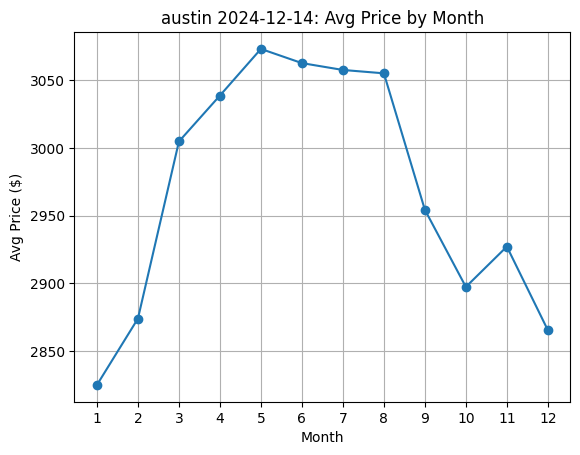

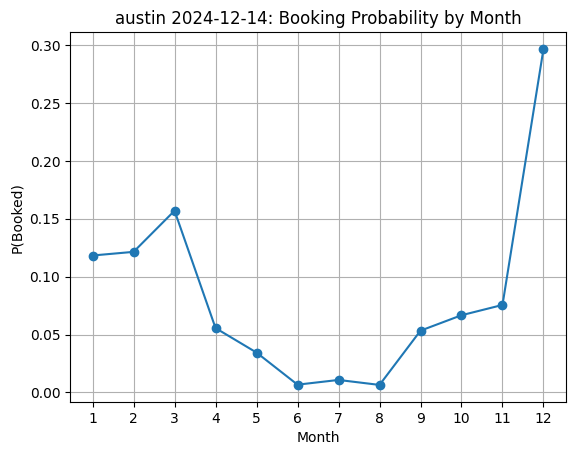

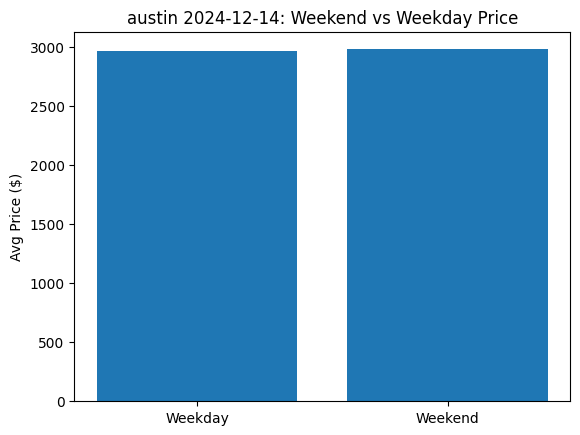

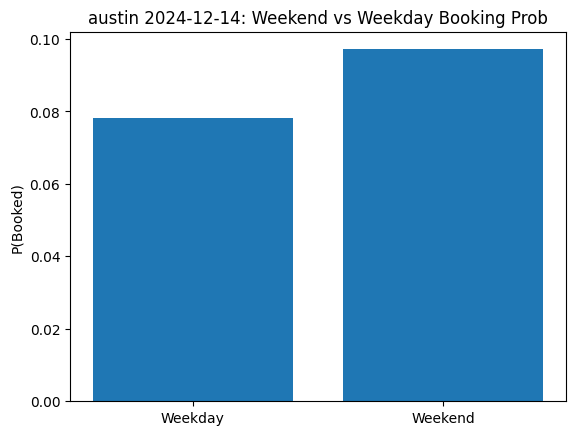

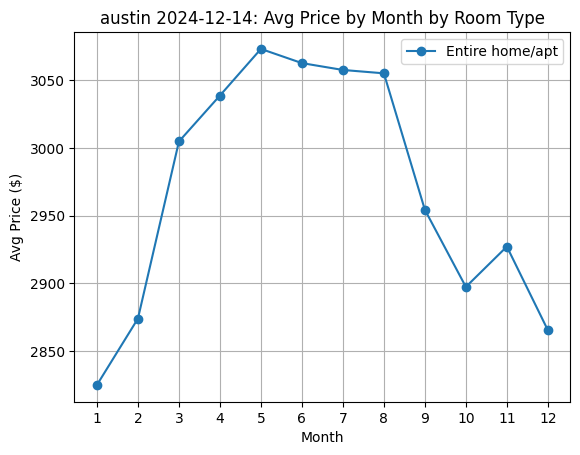


=== austin | 2025-03-06 ===
panel shape: (5119, 31)


,listing_id,date,price,available,isBooked
1537054,35937190,2025-03-12,2500.0,f,1
1537055,35937190,2025-03-13,2500.0,t,0
1537056,35937190,2025-03-14,2900.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/austin_2025-03-06_sample.parquet


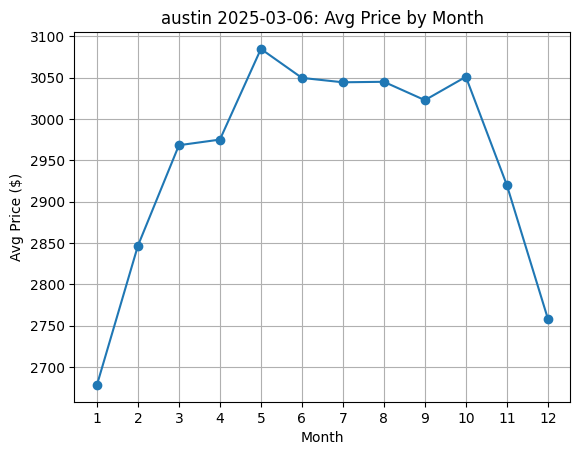

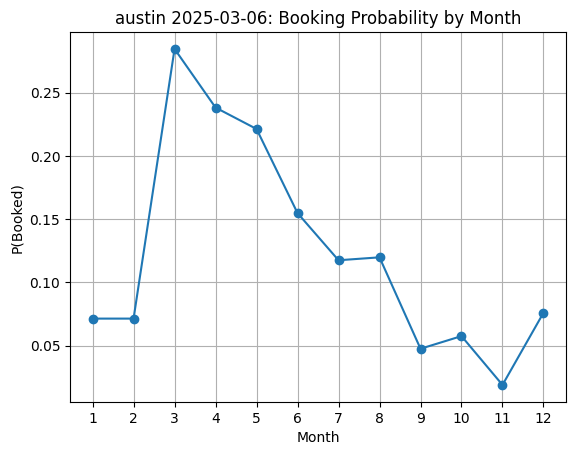

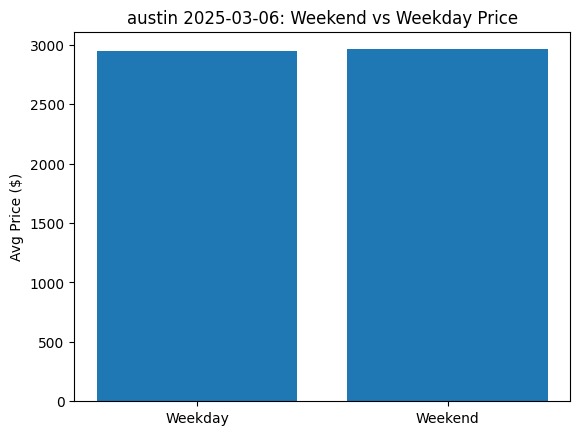

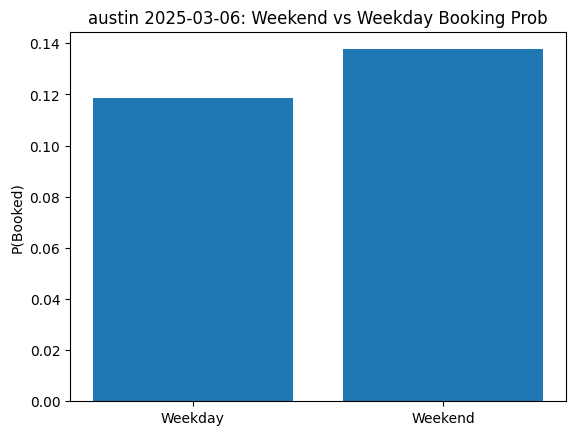

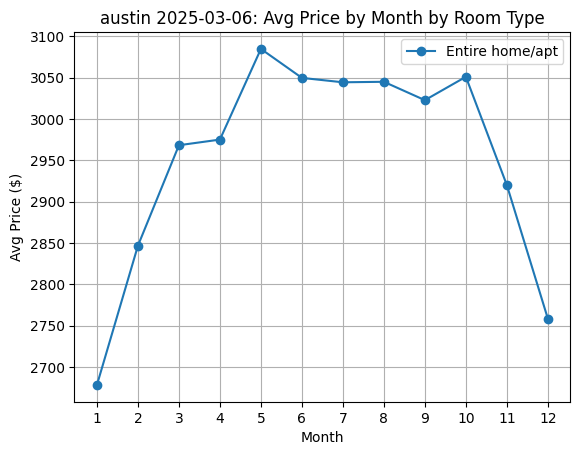


=== chicago | 2024-12-18 ===
panel shape: (730, 31)


,listing_id,date,price,available,isBooked
1533697,740616928303631888,2024-12-18,2100.0,t,0
1533698,740616928303631888,2024-12-19,2100.0,t,0
1533699,740616928303631888,2024-12-20,3000.0,f,1


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/chicago_2024-12-18_sample.parquet


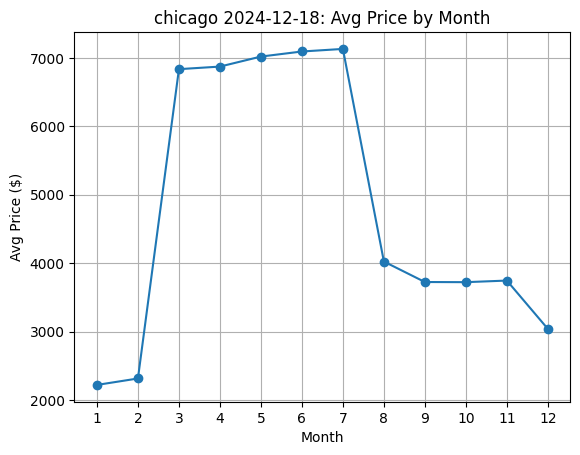

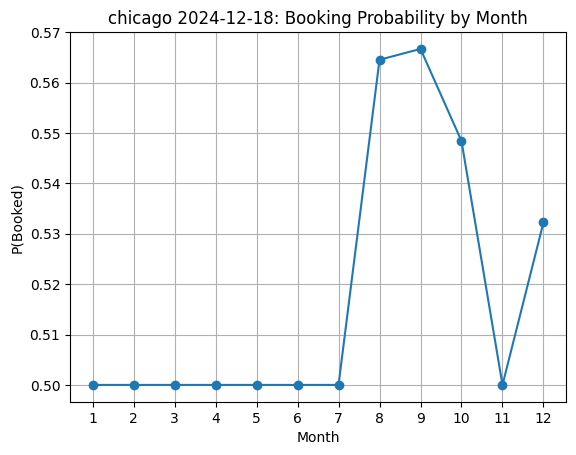

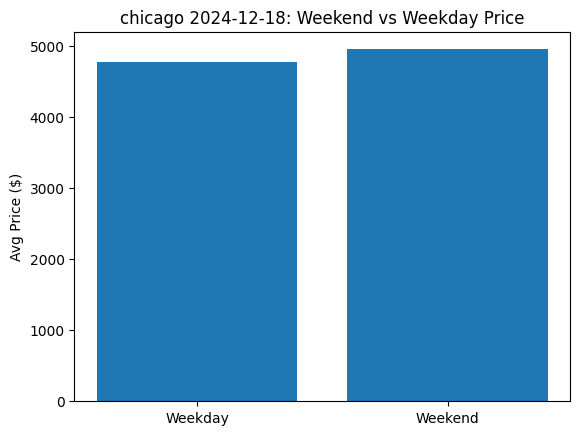

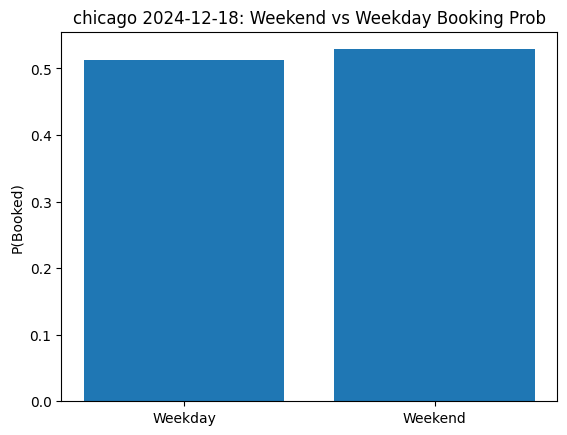

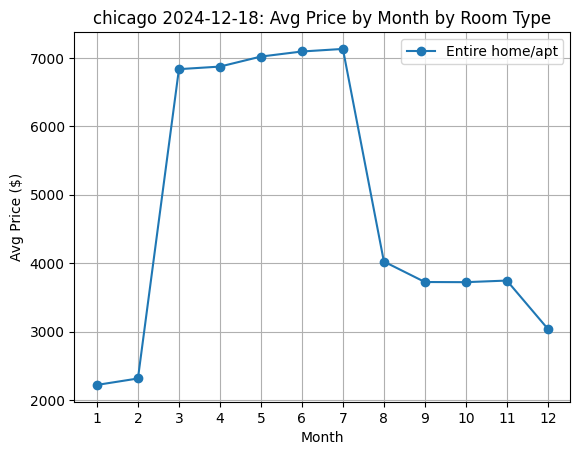


=== chicago | 2025-03-11 ===
panel shape: (730, 31)


,listing_id,date,price,available,isBooked
1471708,740616928303631888,2025-03-12,10500.0,t,0
1471709,740616928303631888,2025-03-13,10500.0,t,0
1471710,740616928303631888,2025-03-14,15000.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/chicago_2025-03-11_sample.parquet


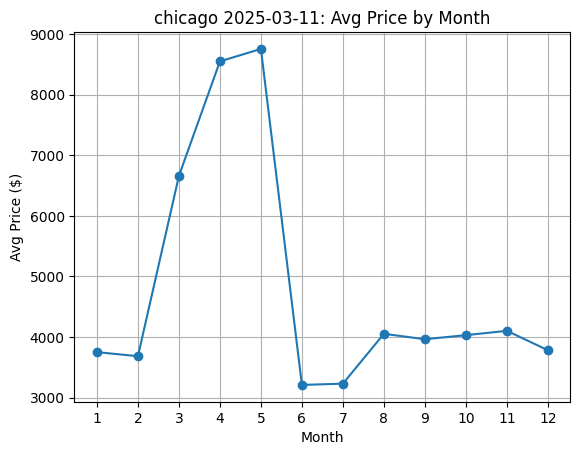

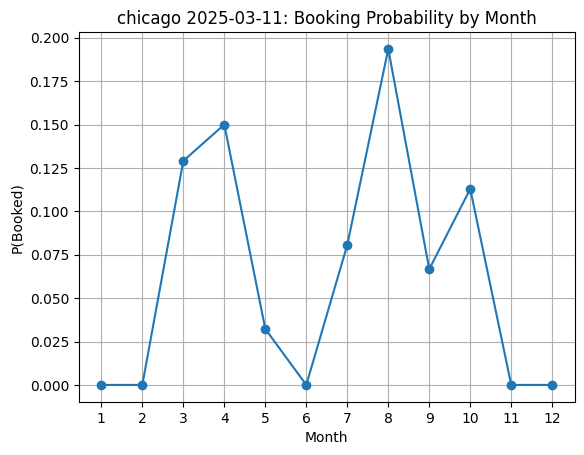

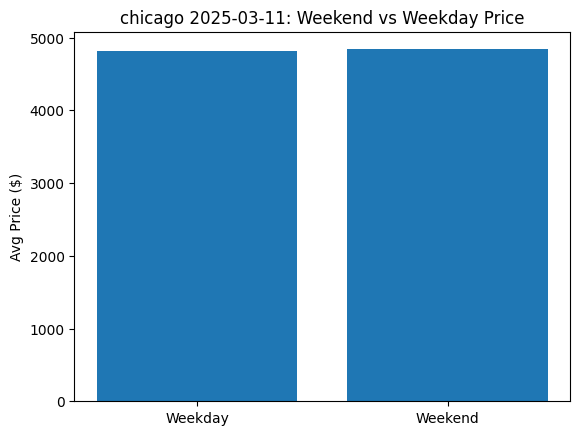

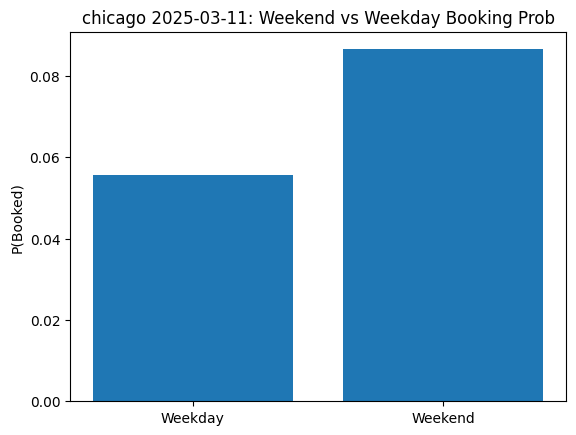

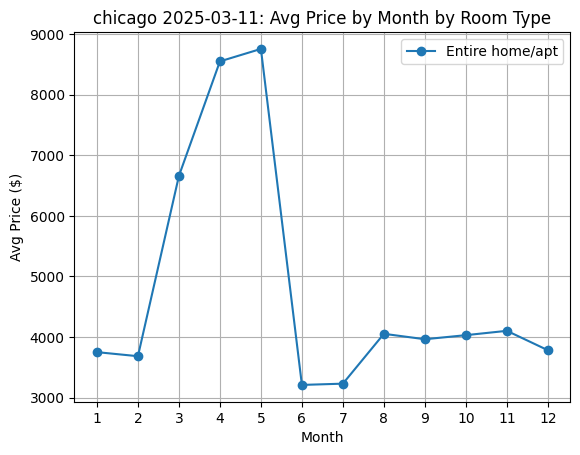


=== santa_cruz | 2024-12-31 ===
panel shape: (620390, 31)


,listing_id,date,price,available,isBooked
0,8357,2024-12-31,145.0,f,1
1,8357,2025-01-01,145.0,f,1
2,8357,2025-01-02,145.0,f,1


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/santa_cruz_2024-12-31_sample.parquet


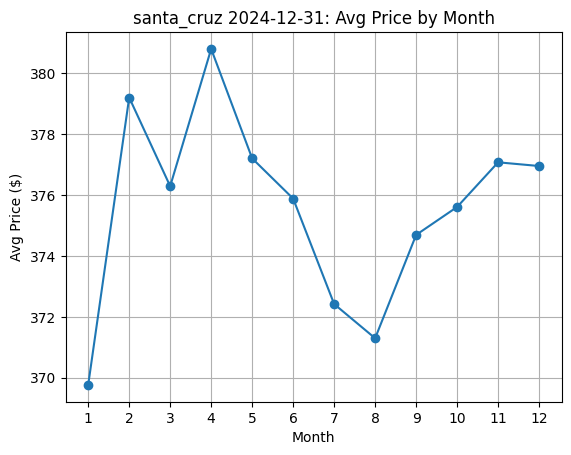

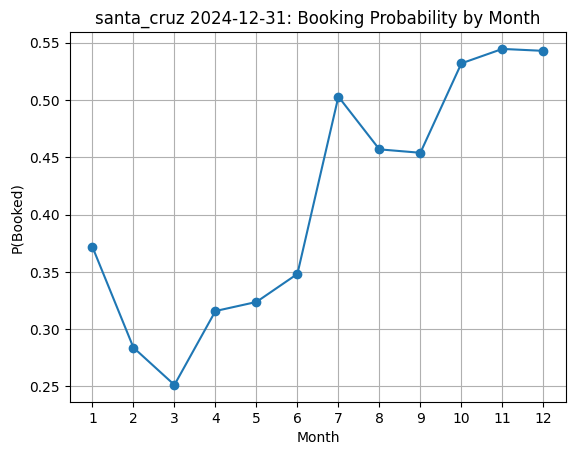

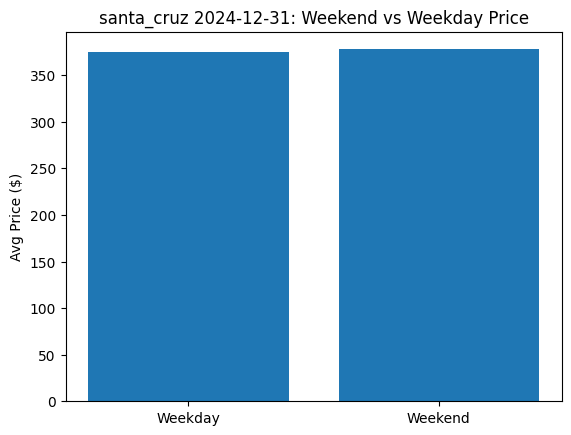

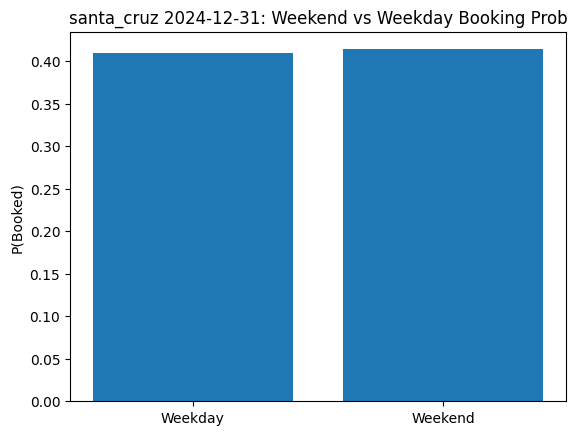

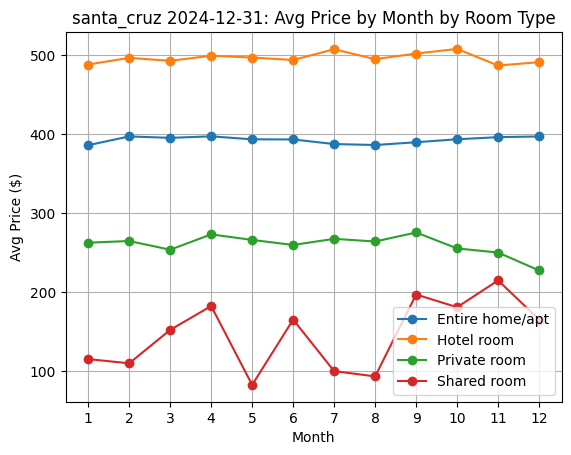


=== santa_cruz | 2025-03-28 ===
panel shape: (613431, 31)


,listing_id,date,price,available,isBooked
0,8357,2025-03-28,145.0,f,1
1,8357,2025-03-29,145.0,f,1
2,8357,2025-03-30,145.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/santa_cruz_2025-03-28_sample.parquet


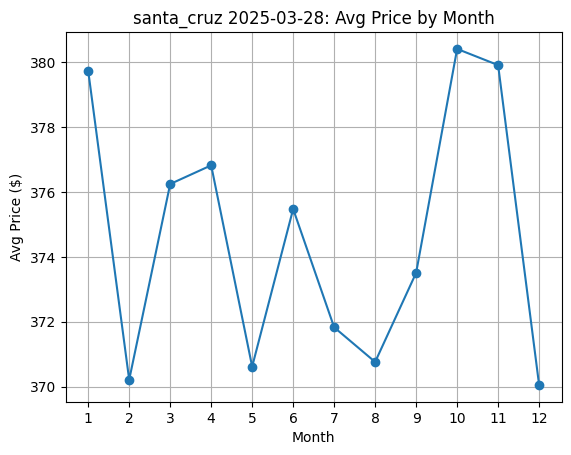

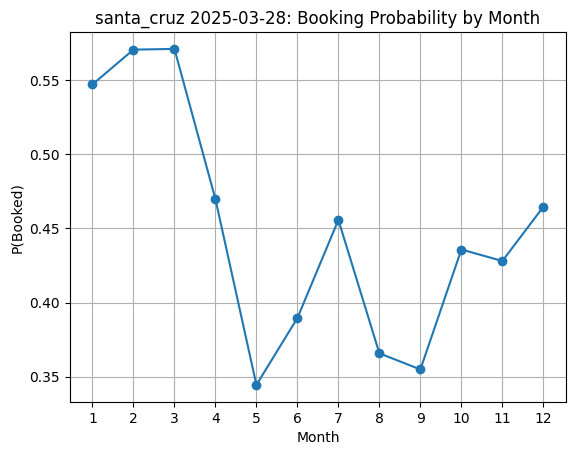

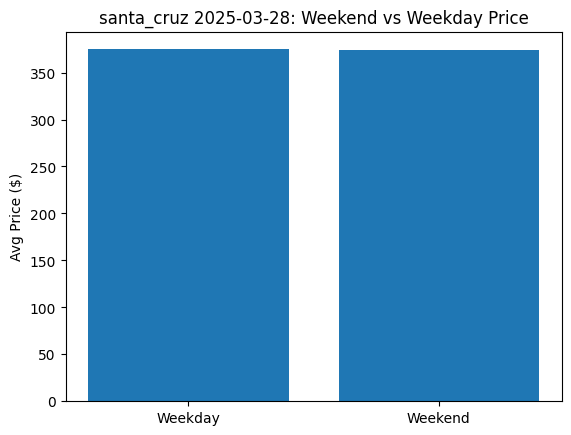

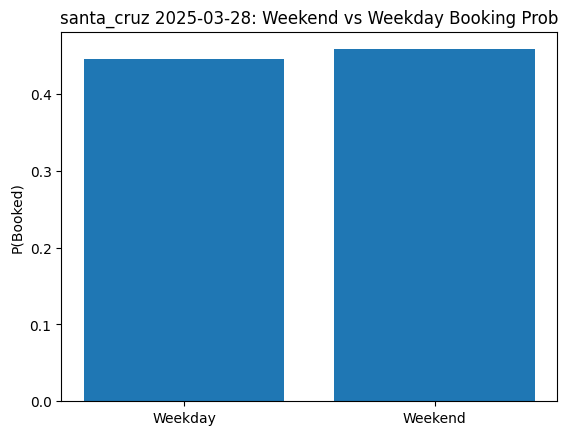

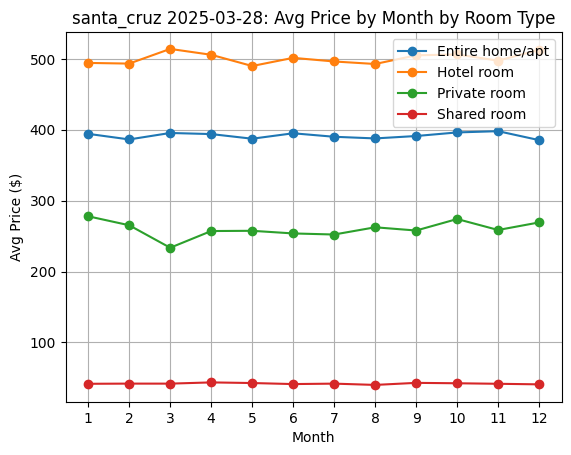


=== washington_dc | 2024-12-18 ===
panel shape: (2176398, 31)


,listing_id,date,price,available,isBooked
0,3686,2024-12-18,67.0,t,0
1,3686,2024-12-19,67.0,t,0
2,3686,2024-12-20,67.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/washington_dc_2024-12-18_sample.parquet


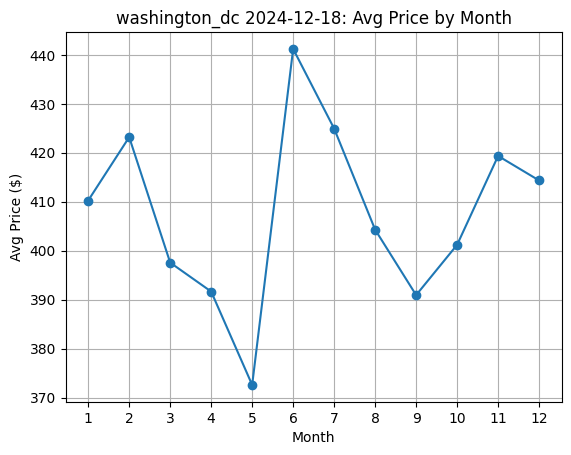

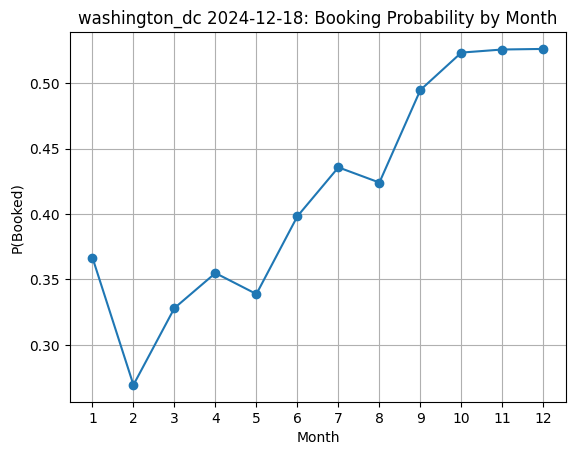

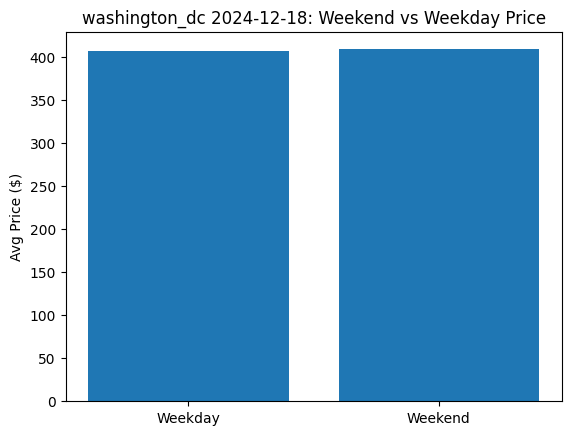

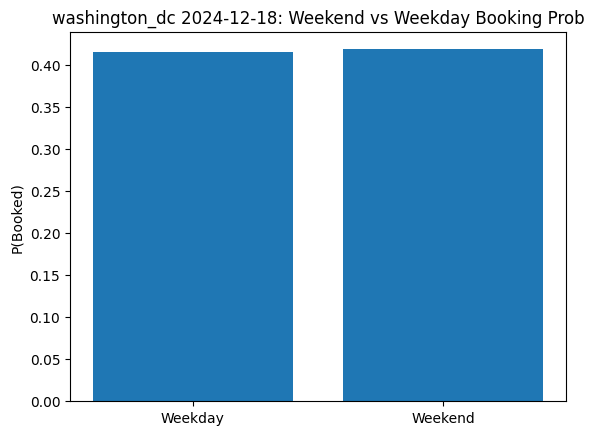

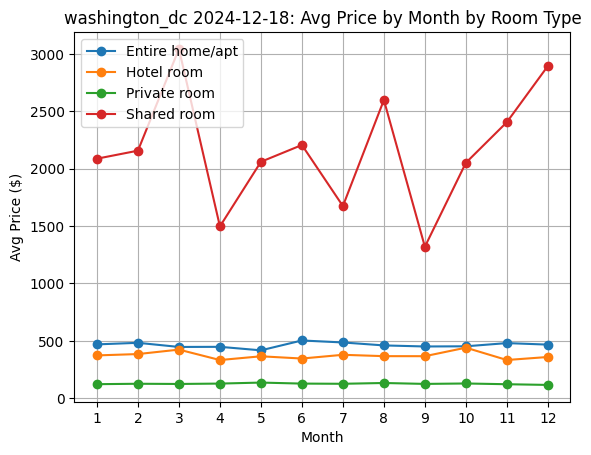


=== washington_dc | 2025-03-13 ===
panel shape: (2282941, 31)


,listing_id,date,price,available,isBooked
0,3686,2025-03-13,67.0,t,0
1,3686,2025-03-14,67.0,t,0
2,3686,2025-03-15,67.0,t,0


saved sample: /Users/hamsikarg/Desktop/insideairbnb-temporal/data/derived/panelSamples/washington_dc_2025-03-13_sample.parquet


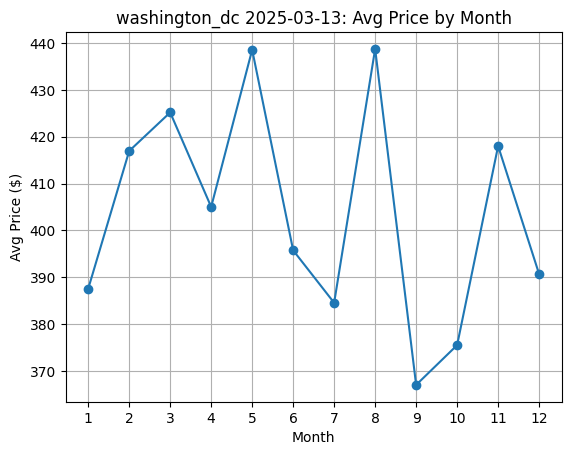

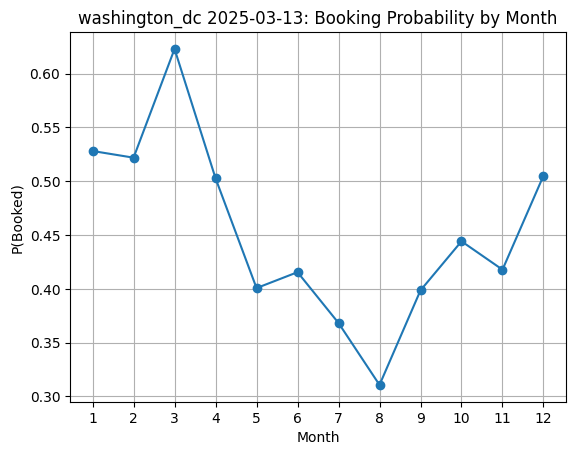

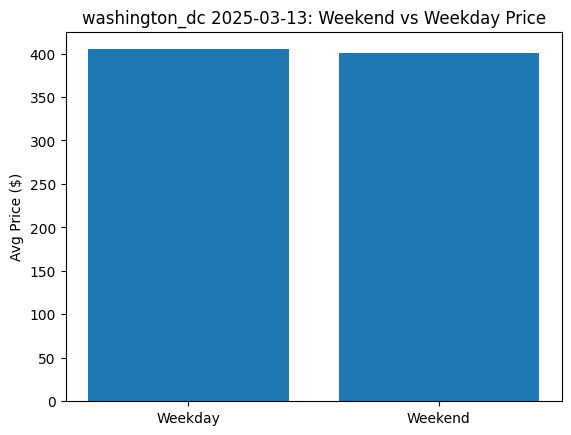

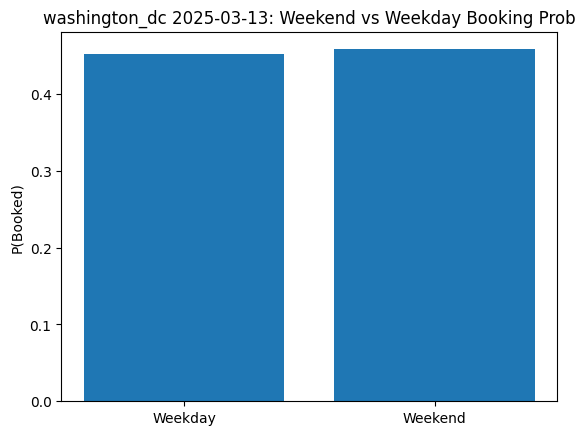

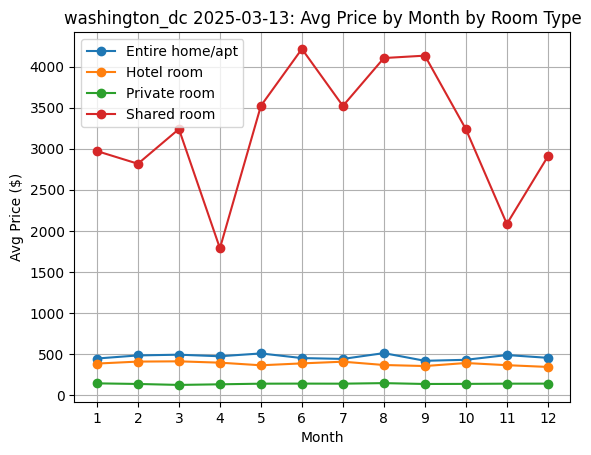

In [42]:
sampleCap = 100_000

for city, snapshots in cities.items():
    for snapshotDate in snapshots:
        print(f"\n=== {city} | {snapshotDate} ===")
        panelDf = buildPanel(city, snapshotDate)

        print("panel shape:", panelDf.shape)
        display(panelDf[["listing_id","date","price","available","isBooked"]].head(3))

        sampleDf = panelDf.sample(n=min(sampleCap, len(panelDf)), random_state=42)
        samplePath = panelSamplesDir / f"{city}_{snapshotDate}_sample.parquet"
        sampleDf.to_parquet(samplePath, index=False)
        print("saved sample:", samplePath)

        byMonth = avgByMonth(sampleDf)
        wk = weekendVsWeekday(sampleDf)
        rt = priceByMonthAndRoomType(sampleDf, topK=6)

        plotMonthlyLine(byMonth, "avgPrice", f"{city} {snapshotDate}: Avg Price by Month", "Avg Price ($)")
        plotMonthlyLine(byMonth, "bookProb", f"{city} {snapshotDate}: Booking Probability by Month", "P(Booked)")

        plotWeekendBars(wk, "avgPrice", f"{city} {snapshotDate}: Weekend vs Weekday Price", "Avg Price ($)")
        plotWeekendBars(wk, "bookProb", f"{city} {snapshotDate}: Weekend vs Weekday Booking Prob", "P(Booked)")

        if rt is not None:
            plotRoomTypeLines(rt, f"{city} {snapshotDate}: Avg Price by Month by Room Type")


To ensure reproducibility and prevent memory issues when working with large city-level panels, a randomly sampled subset (up to 100k rows) of each city+snapshot panel is saved as a parquet file and reused for downstream analysis and modeling.


#### Seasonality Overview 

In all four of these cities, average nightly prices show a relatively smooth and gradual seasonal progression, while their booking probability tends to show sharper and more volatile seasonal rates. Data show that host pricing has a slow response time, while consumer demand responds more strongly to calendar patterns like holidays, peak travel periods, and weekends. Weekend effects also hold across all markets with higher booking probabilities and relatively small price premiums on weekends compared to weekdays. But the power in seasonality for some is more pronounced than others: Austin has more gradual price cycles in response to demand-induced booking moves; Chicago has abrupt, event-driven seasonality; Santa Cruz is relatively stable across months, with large seasonal jumps in demand; Washington, DC has a blend of seasonal tourism and institutional demand. However, there is even more heterogeneity in seasonal behavior across room types. Whole homes and hotel-style listings generally fare better under seasonal price changes, even with private and shared rooms relatively steady. In total, this study shows that booking behavior is more sensitive to the temporal structure than do prices, leading to the implementation of explicit temporal splits and seasonality-aware models.

## Part 3: Temporal Train/Validation/Test Split We implement a strict temporal split to avoid leakage:

- **Train:** January through September  
- **Validation:** October through November  
- **Test:** December through February  

**Equivalent based on snapshot range:** If a snapshot’s calendar range does not contain all these months, we preserve the same logic by assigning:  
- train = earliest available months,  
- validation = next months,  
- test = latest (future-most) months,  
with no random shuffling.

Targets:  
- Regression: price  
- Classification: isBooked  

Features:  
- Listing attributes + time features  
- Exclude raw date, IDs, and free-text fields

In [43]:
def buildPreprocessor(numericCols, categoricalCols):
    numPipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
    catPipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("oneHot", OneHotEncoder(handle_unknown="ignore"))
    ])
    transformers = []
    if len(numericCols) > 0:
        transformers.append(("num", numPipe, numericCols))
    if len(categoricalCols) > 0:
        transformers.append(("cat", catPipe, categoricalCols))
    return ColumnTransformer(transformers)

def chooseFeatureCols(df):
    candidateNumeric = [
        "accommodates","bedrooms","beds","bathrooms",
        "minimum_nights","maximum_nights","minimum_nights_x","maximum_nights_x",
        "number_of_reviews","review_scores_rating",
        "latitude","longitude",
        "weekOfYear","isWeekend",
        "monthSin","monthCos","dowSin","dowCos","doySin","doyCos",
    ]
    candidateCategorical = ["room_type","property_type","neighbourhood_cleansed"]

    numericCols = [c for c in candidateNumeric if c in df.columns]
    categoricalCols = [c for c in candidateCategorical if c in df.columns]
    featureCols = numericCols + categoricalCols
    return featureCols, numericCols, categoricalCols


In [ ]:
def chooseAnchorYear(df: pd.DataFrame) -> int:
    years = sorted(df["date"].dt.year.dropna().unique())
    for y in years:
        months = set(df.loc[df["date"].dt.year == y, "date"].dt.month.unique())
        if (10 in months) or (11 in months):
            return int(y)
    return int(years[0])

def temporalSplitJanSepOctNovDecFeb(df: pd.DataFrame):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    anchorYear = chooseAnchorYear(df)

    trainMask = (df["date"].dt.year == anchorYear) & (df["date"].dt.month.isin(range(1, 10)))   
    validMask = (df["date"].dt.year == anchorYear) & (df["date"].dt.month.isin([10, 11]))       
    testMask  = (
        ((df["date"].dt.year == anchorYear) & (df["date"].dt.month == 12)) |                    
        ((df["date"].dt.year == anchorYear + 1) & (df["date"].dt.month.isin([1, 2])))           
    )

    trainDf = df[trainMask].copy()
    validDf = df[validMask].copy()
    testDf  = df[testMask].copy()

    return trainDf, validDf, testDf, anchorYear

def temporalSplit(df: pd.DataFrame):
    """
    Primary: Jan-Sep / Oct-Nov / Dec-Feb based split.
    Fallback: If those months don't exist in this snapshot range, split chronologically into 3 blocks.
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    trainDf, validDf, testDf, anchorYear = temporalSplitJanSepOctNovDecFeb(df)

    if (len(trainDf) == 0) or (len(validDf) == 0) or (len(testDf) == 0):
        n = len(df)
        i1 = int(n * 0.70)
        i2 = int(n * 0.85)
        trainDf = df.iloc[:i1].copy()
        validDf = df.iloc[i1:i2].copy()
        testDf  = df.iloc[i2:].copy()
        anchorYear = None

    return trainDf, validDf, testDf, anchorYear


In [45]:
runCity = "austin"
runSnapshotDate = "2025-03-06"

samplePath = panelSamplesDir / f"{runCity}_{runSnapshotDate}_sample.parquet"
df = pd.read_parquet(samplePath)

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "price", "available"]).sort_values("date")

trainDf, validDf, testDf, anchorYear = temporalSplit(df)

print("anchorYear:", anchorYear)
print("train/valid/test:", trainDf.shape, validDf.shape, testDf.shape)
print("date ranges:",
      "\n train:", trainDf["date"].min(), "to", trainDf["date"].max(),
      "\n valid:", validDf["date"].min(), "to", validDf["date"].max(),
      "\n test :", testDf["date"].min(),  "to", testDf["date"].max())

featureCols, numericCols, categoricalCols = chooseFeatureCols(df)

xTrain = trainDf[featureCols]
xValid = validDf[featureCols]
xTest  = testDf[featureCols]

yTrainPrice = trainDf["price"]
yValidPrice = validDf["price"]
yTestPrice  = testDf["price"]

yTrainBooked = trainDf["isBooked"].astype(int)
yValidBooked = validDf["isBooked"].astype(int)
yTestBooked  = testDf["isBooked"].astype(int)

print("Booked rate train/valid/test:",
      float(yTrainBooked.mean()), float(yValidBooked.mean()), float(yTestBooked.mean()))


anchorYear: 2025
train/valid/test: (2844, 31) (854, 31) (1260, 31)
date ranges: 
 train: 2025-03-07 00:00:00 to 2025-09-30 00:00:00 
 valid: 2025-10-01 00:00:00 to 2025-11-30 00:00:00 
 test : 2025-12-01 00:00:00 to 2026-02-28 00:00:00
Booked rate train/valid/test: 0.17369901547116737 0.03864168618266979 0.07301587301587302


## Part 4: Modeling (XGBoost + Neural Network + TensorBoard)

We train:
- XGBoost regressor for price
- XGBoost classifier for booked
- Neural Network for price (MSE + MAE)
- Neural Network for booked (binary crossentropy + accuracy + AUC)


In [46]:
def trainXgbPrice(prep, xTrain, yTrain):
    model = XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=2.0,
        random_state=42
    )
    pipe = Pipeline([("prep", prep), ("xgb", model)])
    pipe.fit(xTrain, yTrain)
    return pipe

def trainXgbBooked(prep, xTrain, yTrain):
    yArr = np.asarray(yTrain).astype(int)
    neg = int((yArr == 0).sum())
    pos = int((yArr == 1).sum())
    scalePosWeight = neg / max(1, pos)

    model = XGBClassifier(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=3.0,
        eval_metric="auc",
        scale_pos_weight=scalePosWeight,
        random_state=42
    )
    pipe = Pipeline([("prep", prep), ("xgb", model)])
    pipe.fit(xTrain, yArr)
    return pipe

def evalPrice(pipe, xTest, yTest):
    pred = pipe.predict(xTest)
    return {
        "rmse": float(np.sqrt(mean_squared_error(yTest, pred))),
        "mae": float(mean_absolute_error(yTest, pred))
    }

def evalBooked(pipe, xTest, yTest):
    yArr = np.asarray(yTest).astype(int)
    proba = pipe.predict_proba(xTest)[:, 1]
    pred = (proba >= 0.5).astype(int)
    return {
        "auc": float(roc_auc_score(yArr, proba)),
        "accuracy": float(accuracy_score(yArr, pred)),
        "pr_auc": float(average_precision_score(yArr, proba))
    }

prepBase = buildPreprocessor(numericCols, categoricalCols)

xgbPrice = trainXgbPrice(prepBase, xTrain, yTrainPrice)
xgbBooked = trainXgbBooked(prepBase, xTrain, yTrainBooked)

print("XGB test | price:", evalPrice(xgbPrice, xTest, yTestPrice))
print("XGB test | booked:", evalBooked(xgbBooked, xTest, yTestBooked))


XGB test | price: {'rmse': 469.034583920436, 'mae': 351.3063258579799}
XGB test | booked: {'auc': 0.5870961137581894, 'accuracy': 0.5277777777777778, 'pr_auc': 0.08175231742850878}


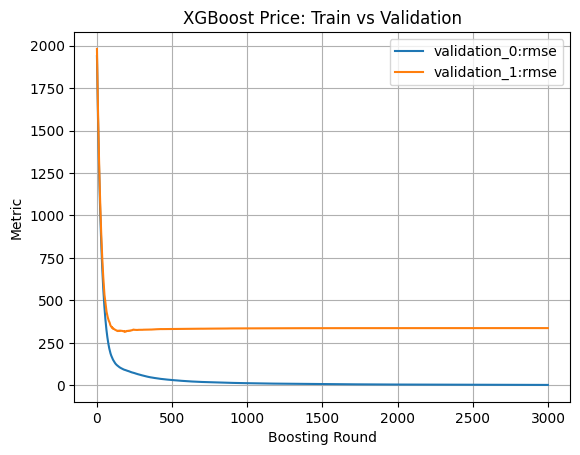

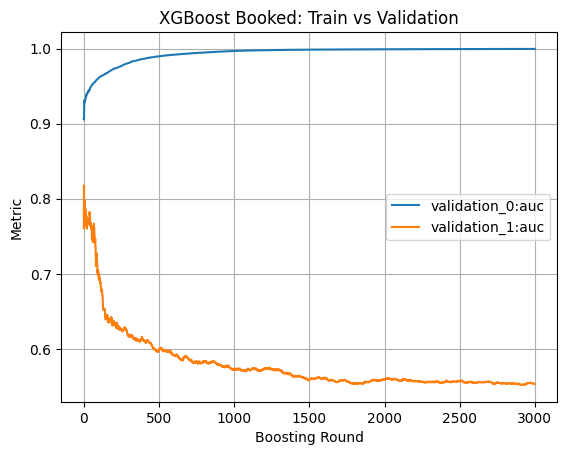

XGB monitored test | price: {'rmse': 469.43962600281196, 'mae': 358.48278052920386}
XGB monitored test | booked: {'auc': 0.4880230047647409, 'accuracy': 0.5563492063492064, 'pr_auc': 0.0648877905728115}


In [ ]:
def trainXgbWithValidationPrice(prep, xTrain, yTrain, xValid, yValid):
    xTrainT = prep.fit_transform(xTrain)
    xValidT = prep.transform(xValid)

    model = XGBRegressor(
        n_estimators=3000,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=2.0,
        random_state=42
    )

    model.fit(
        xTrainT, yTrain,
        eval_set=[(xTrainT, yTrain), (xValidT, yValid)],
        verbose=False
    )
    return prep, model

def trainXgbWithValidationBooked(prep, xTrain, yTrain, xValid, yValid):
    yTrainArr = np.asarray(yTrain).astype(int)
    yValidArr = np.asarray(yValid).astype(int)

    neg = int((yTrainArr == 0).sum())
    pos = int((yTrainArr == 1).sum())
    scalePosWeight = neg / max(1, pos)

    xTrainT = prep.fit_transform(xTrain)
    xValidT = prep.transform(xValid)

    model = XGBClassifier(
        n_estimators=3000,
        learning_rate=0.03,
        max_depth=4,
        min_child_weight=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=3.0,
        eval_metric="auc",
        scale_pos_weight=scalePosWeight,
        random_state=42
    )

    model.fit(
        xTrainT, yTrainArr,
        eval_set=[(xTrainT, yTrainArr), (xValidT, yValidArr)],
        verbose=False
    )
    return prep, model

def plotXgbCurves(model, title):
    evals = model.evals_result()
    plt.figure()
    for datasetName, metricsDict in evals.items():
        for metricName, values in metricsDict.items():
            plt.plot(values, label=f"{datasetName}:{metricName}")
    plt.xlabel("Boosting Round")
    plt.ylabel("Metric")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

prepPriceMon = buildPreprocessor(numericCols, categoricalCols)
prepBookedMon = buildPreprocessor(numericCols, categoricalCols)

prepPriceMon, xgbPriceMon = trainXgbWithValidationPrice(prepPriceMon, xTrain, yTrainPrice, xValid, yValidPrice)
prepBookedMon, xgbBookedMon = trainXgbWithValidationBooked(prepBookedMon, xTrain, yTrainBooked, xValid, yValidBooked)

plotXgbCurves(xgbPriceMon, "XGBoost Price: Train vs Validation")
plotXgbCurves(xgbBookedMon, "XGBoost Booked: Train vs Validation")

xTestPriceT = prepPriceMon.transform(xTest)
xTestBookedT = prepBookedMon.transform(xTest)

pricePred = xgbPriceMon.predict(xTestPriceT)
bookedProba = xgbBookedMon.predict_proba(xTestBookedT)[:, 1]
bookedPred = (bookedProba >= 0.5).astype(int)

print("XGB monitored test | price:", {
    "rmse": float(np.sqrt(mean_squared_error(yTestPrice, pricePred))),
    "mae": float(mean_absolute_error(yTestPrice, pricePred))
})

print("XGB monitored test | booked:", {
    "auc": float(roc_auc_score(np.asarray(yTestBooked).astype(int), bookedProba)),
    "accuracy": float(accuracy_score(np.asarray(yTestBooked).astype(int), bookedPred)),
    "pr_auc": float(average_precision_score(np.asarray(yTestBooked).astype(int), bookedProba))
})


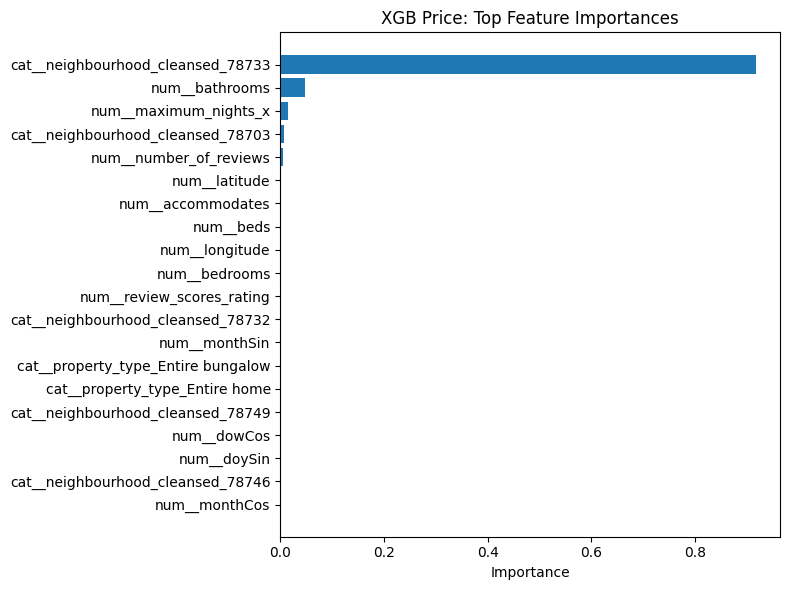

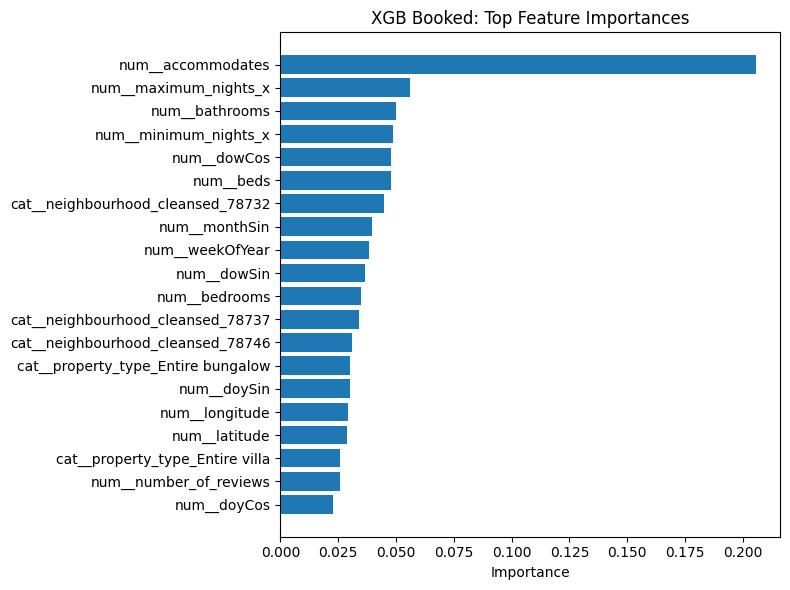

In [48]:
def getFeatureNamesFromPrep(prep):
    try:
        return list(prep.get_feature_names_out())
    except Exception:
        names = []
        for name, trans, cols in prep.transformers_:
            if name == "remainder" and trans == "drop":
                continue
            if hasattr(trans, "get_feature_names_out"):
                names.extend(list(trans.get_feature_names_out(cols)))
            else:
                names.extend(list(cols))
        return names

def plotXgbFeatureImportance(model, featureNames, title, topK=20):
    imp = model.feature_importances_
    k = min(len(imp), len(featureNames))
    imp = imp[:k]
    featureNames = featureNames[:k]

    impDf = (pd.DataFrame({"feature": featureNames, "importance": imp})
             .sort_values("importance", ascending=False)
             .head(topK))

    plt.figure(figsize=(8, 6))
    plt.barh(impDf["feature"][::-1], impDf["importance"][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

featureNamesPrice  = getFeatureNamesFromPrep(prepPriceMon)
featureNamesBooked = getFeatureNamesFromPrep(prepBookedMon)

plotXgbFeatureImportance(xgbPriceMon, featureNamesPrice, "XGB Price: Top Feature Importances", topK=20)
plotXgbFeatureImportance(xgbBookedMon, featureNamesBooked, "XGB Booked: Top Feature Importances", topK=20)


#### Neural Networks + TensorBoard

We train two feedforward neural networks:
- Regression (price): MSE loss with MAE metric
- Classification (bookings): binary crossentropy with accuracy + AUC

We log training to TensorBoard using separate log directories.


In [49]:
tf.keras.backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

def buildNetwork(inputDim, task):
    inp = tf.keras.Input(shape=(inputDim,))
    x = tf.keras.layers.Dense(256, activation="relu")(inp)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    if task == "price":
        out = tf.keras.layers.Dense(1)(x)
        model = tf.keras.Model(inp, out)
        model.compile(optimizer="adam", loss="mse", metrics=["mae"])
        return model

    out = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

def trainWithTensorBoard(
    model, xTrain, yTrain, xValid, yValid,
    logRoot, epochs=15, batchSize=2048,
    class_weight=None
):
    runId = datetime.now().strftime("%Y%m%d-%H%M%S")
    logDir = Path(logRoot) / runId
    tb = tf.keras.callbacks.TensorBoard(log_dir=str(logDir))

    model.fit(
        xTrain, yTrain,
        validation_data=(xValid, yValid),
        epochs=epochs,
        batch_size=batchSize,
        callbacks=[tb],
        class_weight=class_weight,
        verbose=1
    )
    return logDir

prepNn = buildPreprocessor(numericCols, categoricalCols)
xTrainNn = prepNn.fit_transform(xTrain)
xValidNn = prepNn.transform(xValid)
xTestNn  = prepNn.transform(xTest)

xTrainNn = xTrainNn.toarray().astype("float32") if hasattr(xTrainNn, "toarray") else xTrainNn.astype("float32")
xValidNn = xValidNn.toarray().astype("float32") if hasattr(xValidNn, "toarray") else xValidNn.astype("float32")
xTestNn  = xTestNn.toarray().astype("float32") if hasattr(xTestNn, "toarray") else xTestNn.astype("float32")

nnPrice = buildNetwork(xTrainNn.shape[1], "price")
priceLogDir = trainWithTensorBoard(
    nnPrice,
    xTrainNn, yTrainPrice.values,
    xValidNn, yValidPrice.values,
    nnPriceLogsDir
)
print("NN price test:", nnPrice.evaluate(xTestNn, yTestPrice.values, verbose=0), "logDir:", priceLogDir)

yTrainBookedArr = np.asarray(yTrainBooked.values).astype(int)
yValidBookedArr = np.asarray(yValidBooked.values).astype(int)
yTestBookedArr  = np.asarray(yTestBooked.values).astype(int)

neg = int((yTrainBookedArr == 0).sum())
pos = int((yTrainBookedArr == 1).sum())
class_weight = {0: 1.0, 1: neg / max(1, pos)}
print("Class weight used:", class_weight)

nnBooked = buildNetwork(xTrainNn.shape[1], "booked")
bookedLogDir = trainWithTensorBoard(
    nnBooked,
    xTrainNn, yTrainBookedArr,
    xValidNn, yValidBookedArr,
    nnBookedLogsDir,
    class_weight=class_weight
)
print("NN booked test:", nnBooked.evaluate(xTestNn, yTestBookedArr, verbose=0), "logDir:", bookedLogDir)

probaTest = nnBooked.predict(xTestNn).ravel()
probaValid = nnBooked.predict(xValidNn).ravel()

print("Observed test booked rate:", float(yTestBookedArr.mean()))
print("Mean predicted probability:", float(probaTest.mean()))
print("AUC:", float(roc_auc_score(yTestBookedArr, probaTest)))
print("PR-AUC:", float(average_precision_score(yTestBookedArr, probaTest)))
print("Proba percentiles:", np.percentile(probaTest, [50, 75, 90, 95, 99]))

ths = np.linspace(0.01, 0.99, 99)
best = {"thr": None, "f1": -1, "prec": None, "rec": None}

for t in ths:
    predV = (probaValid >= t).astype(int)
    f1 = f1_score(yValidBookedArr, predV, zero_division=0)
    if f1 > best["f1"]:
        best = {
            "thr": float(t),
            "f1": float(f1),
            "prec": float(precision_score(yValidBookedArr, predV, zero_division=0)),
            "rec": float(recall_score(yValidBookedArr, predV, zero_division=0))
        }

print("Best VALID threshold:", best)

predT = (probaTest >= best["thr"]).astype(int)
print("TEST predicted booked rate:", float(predT.mean()))
print("TEST accuracy:", float(accuracy_score(yTestBookedArr, predT)))
print("TEST precision:", float(precision_score(yTestBookedArr, predT, zero_division=0)))
print("TEST recall:", float(recall_score(yTestBookedArr, predT, zero_division=0)))
print("TEST F1:", float(f1_score(yTestBookedArr, predT, zero_division=0)))


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 13703594.0000 - mae: 3108.4270 - val_loss: 12882738.0000 - val_mae: 2957.8823
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12936062.0000 - mae: 2994.7334 - val_loss: 12169563.0000 - val_mae: 2845.7041
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12234841.0000 - mae: 2884.2356 - val_loss: 11484346.0000 - val_mae: 2733.2502
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11540150.0000 - mae: 2772.0667 - val_loss: 10835850.0000 - val_mae: 2621.4504
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10885759.0000 - mae: 2659.5854 - val_loss: 10193843.0000 - val_mae: 2505.2297
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10229073.0000 - mae: 2541.7317 - val_loss: 9570959.0000 - val_mae: 2386.1511
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9607591.0000 - mae: 2422.7808 - val_loss: 8945819.0000 - val_mae: 2259.0430
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8

## TensorBoard

Run TensorBoard below, take screenshots of scalar plots (loss + metrics) for both models, and paste them into Markdown cells.


In [50]:
%load_ext tensorboard
%tensorboard --logdir ../logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 35718), started 0:27:24 ago. (Use '!kill 35718' to kill it.)

## TensorBoard Results

### Neural Network – Price Prediction
The following plots show training and validation behavior for the price regression model.

**Loss (MSE):**  
![](../reports/tensorboardScreens/nn_price_loss.png)

**Mean Absolute Error (MAE):**  
![](../reports/tensorboardScreens/nn_price_mae.png)

---

### Neural Network – Booking Prediction
The following plots show training and validation behavior for the booking classification model.

**AUC:**  
![](../reports/tensorboardScreens/nn_booked_auc.png)

**Accuracy:**  
![](../reports/tensorboardScreens/nn_booked_accuracy.png)


### Summary

#### Data and Seasonality Patterns. 

For this project we create a night-level panel dataset by taking InsideAirbnb calendar and listing for night basis data combined; so one observation per listing per date is seen. For all four cities, average nightly prices have fairly symmetrical seasonal variability, with booking probability exhibiting more severe and sporadic variation. Weekend effects are consistent from market to market, higher booking probabilities and modest price premiums on weekends. Seasonal intensity differs by city: Austin has gradual price cycles while Chicago has intense seasonal events, Santa Cruz is subject to relatively consistent pricing with demand-driven booking swings, and Washington DC is composed of seasonal tourist attraction prices and institutional demand.

#### Compared Model Performance. 

Under strict temporal evaluation, XGBoost models provide excellent performance on training data but with limited generalizability. It was revealed from feature importance analysis that the model heavily depends on static listing attributes: neighborhood, capacity, and bathrooms are features it considers in depth, hinting that this tree-based approach does very limited generalization across variables. The performance of validation plateaus early, indicating a hard time extending seasonal dynamics into subsequent months. As opposed to the earlier paper, neural network models exhibit a relatively smoother convergence, better alignment of training and validation curves, and more robust performance on the test set (again for booking prediction).

#### TensorBoard Interpretation 

For the price network, both training and validation losses decrease smoothly and show stability, without divergence. The gap between training and validation curves grows slightly near later epochs, representing mild overfitting and limited ability to extrapolate price patterns into unseen months. This corresponds with the results obtained from the final test whereby price errors are relatively high since pricing is based primarily on location and listing attributes. In the case of the booking network, the validation AUC gradually improves and generally tracks the training AUC, suggesting that the model learns an actual ranking signal and does not memorize training data. Small fluctuations are expected because of class imbalance and the greater variability of booking behavior. In summary, temporal features are more beneficial for booking prediction than price prediction, and TensorBoard confirms the booking model generalizes well under a strict temporal split.

#### Generalization to unseen months 

Under practical forecasting circumstances (training on Jan–Sep, validating on Oct–Nov, and testing on Dec–Feb), neural networks generalize more with greater accuracy to the unseen future months than XGBoost. As XGBoost has pretty good training metrics, it performs badly when it comes to validation and testing over time. In contrast, neural networks produce consistent performance across validation and test periods and are much more robust to seasonality changes and calendar effects.

#### Business Insights. 

The probability of booking is more predictable, more influenced by temporal pattern and more valuable as an operational target than being priced. Accurate Booking Forecasts can support dynamic Pricing, Availability, Staffing decisions, and Capacity Planning. Location-specific and structural factors limit the forward-looking accuracy of price prediction. In summary, this study implies the need for temporal structure respect and seasonal forecasting systems for real world demand forecasting in the marketplace (i.e., seasonality)-aware model for real-world forecasting construction system on the marketplace demand.